<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Présentation-du-projet" data-toc-modified-id="Présentation-du-projet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Présentation du projet</a></span></li><li><span><a href="#Péparation-des-données" data-toc-modified-id="Péparation-des-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Péparation des données</a></span><ul class="toc-item"><li><span><a href="#Visualisation" data-toc-modified-id="Visualisation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualisation</a></span></li></ul></li><li><span><a href="#GAN" data-toc-modified-id="GAN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GAN</a></span><ul class="toc-item"><li><span><a href="#Generator" data-toc-modified-id="Generator-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Discriminateur" data-toc-modified-id="Discriminateur-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Discriminateur</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Résultats-par-GAN" data-toc-modified-id="Résultats-par-GAN-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Résultats par GAN</a></span></li></ul></li><li><span><a href="#TEST-ZONE" data-toc-modified-id="TEST-ZONE-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>TEST ZONE</a></span></li></ul></div>

# Présentation du projet


Dans ce projet, on va utiliser un GAN et un AE sur la base de données MNIST et les comparer.


# Péparation des données

In [1]:
# torch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F


# torchsummary and torchvision
from torchsummary import summary
import torchvision
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.utils as vutils

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time


CUDA = False and torch.cuda.is_available()
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
REAL_LABEL = 1
FAKE_LABEL = 0
seed = 1

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


dataset = datasets.MNIST(root='data', download=True,
                     transform=torchvision.transforms.Compose([
                     torchvision.transforms.Resize(X_DIM),
                     torchvision.transforms.ToTensor(),
                     torchvision.transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)


## Visualisation

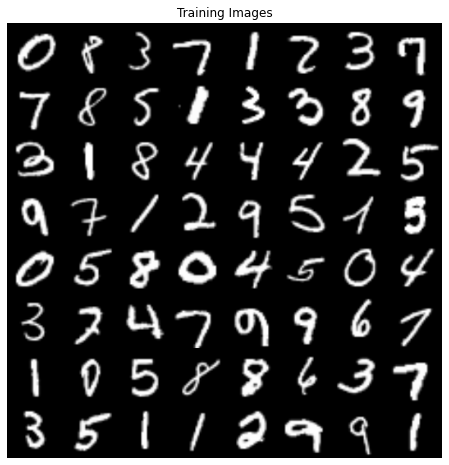

In [3]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


# GAN

## Generator


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## Discriminateur

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

## Training

In [9]:
EPOCH_NUM = 5
lr = 0.001


# Create the generator
generator = Generator().to(device)
#generator.apply(weights_init)
generator.load_state_dict(torch.load("MODEL/genarator"))
generator.eval()
print(generator)

# Create the discriminator
discriminator = Discriminator().to(device)
#discriminator.apply(weights_init)
generator.load_state_dict(torch.load("MODEL/genarator"))
generator.eval()
print(discriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

> TRÉS LONG À COMPILER !!!

In [11]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        generator.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.4672	Loss_G: 13.9034	D(x): 0.6042	D(G(z)): 0.6072 / 0.0000
[0/5][50/469]	Loss_D: 2.9033	Loss_G: 4.6404	D(x): 0.8985	D(G(z)): 0.9272 / 0.0134
[0/5][100/469]	Loss_D: 1.4901	Loss_G: 1.1150	D(x): 0.4198	D(G(z)): 0.4146 / 0.3548
[0/5][150/469]	Loss_D: 1.1049	Loss_G: 2.0837	D(x): 0.6400	D(G(z)): 0.4321 / 0.1648
[0/5][200/469]	Loss_D: 1.2541	Loss_G: 1.8006	D(x): 0.6622	D(G(z)): 0.5234 / 0.1894
[0/5][250/469]	Loss_D: 1.1215	Loss_G: 0.9949	D(x): 0.5459	D(G(z)): 0.3616 / 0.4044
[0/5][300/469]	Loss_D: 1.3025	Loss_G: 1.6203	D(x): 0.7353	D(G(z)): 0.5976 / 0.2220
[0/5][350/469]	Loss_D: 3.0447	Loss_G: 0.2571	D(x): 0.0615	D(G(z)): 0.0528 / 0.7868
[0/5][400/469]	Loss_D: 1.1749	Loss_G: 1.1600	D(x): 0.5833	D(G(z)): 0.4378 / 0.3278
[0/5][450/469]	Loss_D: 0.9939	Loss_G: 1.0191	D(x): 0.6135	D(G(z)): 0.3601 / 0.3811
[1/5][0/469]	Loss_D: 1.3518	Loss_G: 2.1257	D(x): 0.7836	D(G(z)): 0.6419 / 0.1362
[1/5][50/469]	Loss_D: 1.1644	Loss_G: 0.9672	D(x): 0.4761	D(G(z)):

In [12]:
torch.save(generator.state_dict(), "MODEL/genarator")
torch.save(discriminator.state_dict(), "MODEL/discriminator")

## Résultats par GAN

In [ ]:
# Si non run le training et recupérer l'ancien training
img_list = []
fake = generator(viz_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

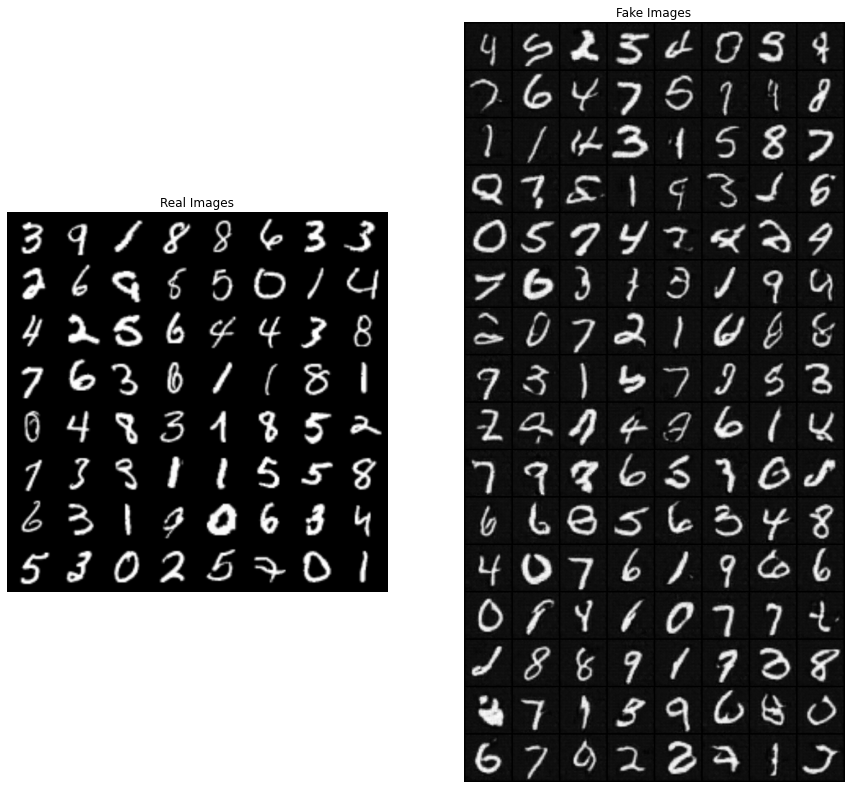

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# TEST ZONE

In [87]:
for i, data in enumerate(dataloader, 0):
    #print(i)
    print(data[1])


0
tensor([2, 8, 2, 0, 0, 8, 5, 5, 3, 5, 7, 9, 5, 7, 8, 6, 9, 5, 4, 7, 0, 3, 0, 1,
        1, 1, 2, 9, 8, 0, 0, 4, 6, 0, 0, 4, 1, 6, 8, 8, 2, 1, 5, 6, 6, 5, 4, 1,
        9, 1, 3, 1, 8, 2, 1, 0, 6, 6, 1, 4, 8, 3, 8, 4, 0, 6, 9, 6, 6, 0, 2, 4,
        5, 0, 2, 7, 3, 3, 0, 2, 1, 9, 0, 1, 8, 1, 8, 5, 9, 1, 6, 1, 3, 1, 6, 4,
        0, 5, 5, 5, 8, 1, 8, 8, 8, 1, 8, 4, 6, 6, 3, 3, 9, 2, 5, 4, 5, 6, 4, 2,
        2, 6, 0, 8, 2, 2, 4, 2])
1
tensor([3, 0, 3, 7, 8, 1, 3, 9, 1, 5, 3, 3, 9, 9, 7, 2, 4, 4, 2, 0, 4, 9, 2, 6,
        4, 1, 7, 1, 3, 1, 7, 7, 4, 8, 1, 5, 7, 0, 2, 3, 9, 8, 8, 2, 3, 6, 8, 1,
        3, 0, 4, 6, 7, 5, 0, 4, 0, 7, 9, 1, 1, 9, 2, 7, 7, 7, 8, 3, 2, 6, 4, 2,
        6, 0, 6, 7, 7, 8, 9, 0, 9, 0, 4, 2, 2, 3, 0, 2, 7, 4, 9, 3, 1, 4, 1, 1,
        6, 5, 1, 9, 6, 1, 7, 7, 1, 2, 1, 4, 1, 9, 2, 4, 1, 1, 2, 5, 8, 8, 2, 8,
        1, 3, 4, 2, 4, 6, 7, 0])
2
tensor([2, 1, 3, 8, 1, 8, 2, 2, 2, 4, 7, 0, 7, 7, 7, 3, 2, 6, 5, 0, 4, 2, 6, 0,
        2, 3, 5, 4, 8, 1, 9, 9, 9, 7, 5, 8, 5, 6

tensor([2, 9, 8, 5, 4, 9, 4, 3, 3, 6, 3, 8, 1, 9, 7, 8, 1, 2, 0, 9, 0, 3, 9, 1,
        3, 9, 2, 7, 6, 3, 6, 8, 6, 3, 5, 3, 7, 9, 4, 9, 1, 0, 1, 3, 6, 4, 3, 6,
        0, 9, 0, 3, 1, 1, 6, 9, 9, 5, 9, 6, 2, 6, 8, 4, 7, 0, 3, 3, 1, 4, 2, 1,
        5, 6, 9, 7, 5, 4, 1, 5, 0, 9, 5, 1, 6, 9, 6, 9, 2, 9, 8, 0, 7, 3, 6, 2,
        6, 7, 9, 2, 6, 4, 3, 3, 0, 5, 5, 5, 9, 2, 5, 3, 5, 1, 8, 2, 6, 7, 2, 6,
        4, 6, 2, 7, 4, 9, 9, 7])
20
tensor([1, 3, 2, 3, 3, 1, 2, 7, 6, 4, 6, 7, 9, 4, 1, 3, 7, 5, 4, 1, 3, 2, 1, 5,
        2, 3, 2, 2, 2, 9, 8, 4, 6, 4, 3, 2, 2, 7, 3, 2, 7, 3, 5, 8, 6, 1, 4, 4,
        0, 7, 2, 2, 1, 0, 9, 6, 1, 9, 5, 1, 7, 9, 3, 0, 1, 3, 9, 4, 4, 7, 7, 1,
        6, 4, 3, 0, 2, 8, 0, 7, 7, 8, 1, 4, 0, 6, 7, 9, 2, 5, 5, 0, 7, 1, 6, 5,
        9, 6, 7, 2, 6, 0, 9, 1, 6, 0, 8, 0, 7, 6, 5, 0, 2, 0, 5, 6, 3, 4, 4, 9,
        0, 6, 9, 3, 5, 6, 4, 2])
21
tensor([1, 4, 0, 2, 5, 0, 1, 4, 2, 4, 1, 5, 2, 1, 2, 9, 7, 4, 9, 5, 0, 3, 7, 5,
        8, 9, 7, 3, 3, 2, 6, 1, 7, 3, 6, 3, 1, 7

39
tensor([3, 5, 3, 5, 5, 9, 4, 8, 0, 5, 6, 0, 3, 9, 8, 5, 7, 2, 8, 9, 2, 6, 3, 3,
        0, 9, 8, 9, 5, 9, 3, 3, 7, 6, 3, 0, 4, 2, 4, 1, 8, 1, 0, 0, 0, 5, 2, 3,
        6, 4, 9, 4, 4, 0, 7, 1, 7, 5, 3, 4, 7, 0, 9, 2, 1, 9, 6, 1, 1, 6, 1, 8,
        6, 8, 8, 1, 7, 8, 0, 5, 1, 8, 6, 0, 3, 9, 9, 5, 8, 6, 4, 6, 1, 1, 8, 0,
        8, 2, 2, 3, 7, 5, 2, 6, 3, 8, 3, 0, 4, 0, 4, 9, 0, 7, 2, 5, 1, 3, 7, 0,
        8, 0, 4, 2, 6, 1, 9, 6])
40
tensor([2, 5, 4, 1, 1, 8, 4, 4, 5, 3, 7, 3, 4, 8, 8, 7, 0, 0, 9, 3, 3, 5, 4, 6,
        3, 1, 4, 0, 2, 9, 9, 9, 6, 5, 7, 9, 8, 9, 7, 3, 6, 8, 0, 9, 0, 2, 1, 3,
        8, 9, 0, 7, 6, 3, 5, 3, 1, 5, 2, 1, 8, 8, 2, 6, 2, 2, 0, 7, 7, 1, 9, 4,
        7, 3, 3, 3, 3, 1, 6, 5, 5, 5, 3, 1, 5, 9, 4, 1, 3, 6, 7, 7, 6, 7, 0, 2,
        0, 7, 1, 8, 2, 4, 4, 1, 4, 9, 2, 8, 1, 6, 1, 0, 8, 1, 3, 8, 2, 3, 1, 5,
        8, 4, 1, 0, 5, 6, 3, 6])
41
tensor([7, 8, 7, 8, 6, 7, 6, 6, 6, 6, 0, 8, 2, 6, 7, 0, 2, 6, 7, 0, 0, 1, 1, 6,
        0, 0, 2, 7, 4, 2, 7, 6, 2, 7, 6, 3, 1

tensor([6, 3, 0, 6, 1, 2, 9, 2, 3, 4, 0, 4, 5, 8, 9, 9, 2, 7, 1, 0, 3, 8, 9, 6,
        9, 9, 1, 6, 0, 8, 1, 7, 9, 1, 8, 4, 2, 9, 5, 3, 0, 3, 3, 8, 7, 4, 5, 1,
        1, 3, 5, 1, 4, 3, 6, 4, 7, 6, 2, 4, 0, 4, 4, 2, 5, 2, 1, 7, 6, 5, 9, 0,
        3, 0, 6, 1, 0, 1, 0, 8, 8, 0, 1, 9, 4, 9, 8, 5, 6, 5, 4, 0, 3, 2, 7, 9,
        5, 9, 5, 5, 8, 8, 9, 8, 9, 9, 7, 5, 5, 0, 8, 9, 2, 0, 0, 7, 9, 8, 6, 9,
        7, 6, 2, 2, 2, 6, 2, 8])
76
tensor([1, 1, 9, 6, 9, 3, 3, 7, 1, 1, 3, 8, 6, 4, 8, 6, 7, 0, 2, 7, 4, 5, 8, 1,
        4, 0, 4, 1, 0, 9, 7, 3, 1, 8, 2, 7, 0, 2, 3, 1, 6, 0, 4, 3, 3, 8, 8, 5,
        3, 7, 3, 0, 3, 3, 8, 4, 0, 2, 5, 7, 5, 3, 8, 4, 7, 3, 7, 8, 7, 6, 3, 2,
        5, 4, 4, 1, 7, 7, 4, 7, 5, 4, 6, 9, 3, 1, 5, 8, 4, 6, 0, 3, 8, 1, 3, 0,
        4, 1, 6, 8, 0, 1, 5, 3, 7, 9, 4, 3, 8, 7, 7, 3, 8, 0, 4, 3, 5, 1, 3, 4,
        0, 4, 2, 5, 7, 0, 7, 2])
77
tensor([9, 6, 7, 7, 2, 1, 7, 4, 0, 6, 0, 0, 3, 9, 5, 4, 1, 4, 4, 4, 8, 8, 2, 9,
        3, 8, 0, 8, 6, 1, 0, 7, 6, 8, 4, 2, 9, 2

112
tensor([4, 0, 3, 1, 1, 2, 4, 1, 1, 3, 8, 3, 3, 6, 9, 0, 9, 8, 0, 6, 3, 2, 2, 5,
        9, 3, 7, 2, 6, 0, 7, 8, 5, 2, 3, 8, 4, 2, 7, 1, 8, 9, 2, 5, 7, 8, 1, 7,
        3, 3, 9, 4, 4, 1, 1, 4, 2, 3, 5, 7, 1, 0, 1, 1, 8, 1, 8, 4, 6, 1, 0, 7,
        7, 6, 4, 7, 4, 0, 5, 9, 5, 6, 9, 9, 2, 1, 4, 5, 1, 8, 8, 1, 9, 8, 8, 8,
        9, 9, 4, 2, 6, 8, 9, 5, 6, 1, 3, 7, 1, 6, 1, 8, 0, 4, 3, 0, 7, 4, 1, 7,
        6, 4, 4, 2, 4, 8, 9, 0])
113
tensor([2, 8, 1, 1, 2, 8, 1, 5, 7, 6, 7, 1, 4, 1, 3, 2, 9, 6, 4, 4, 1, 3, 7, 4,
        9, 0, 1, 6, 9, 1, 6, 3, 9, 9, 0, 3, 8, 9, 3, 3, 0, 7, 2, 8, 2, 3, 9, 1,
        6, 2, 1, 4, 2, 1, 7, 7, 4, 5, 9, 4, 8, 5, 6, 1, 8, 9, 1, 1, 9, 9, 8, 8,
        2, 2, 8, 7, 7, 2, 3, 8, 6, 6, 9, 4, 5, 2, 8, 0, 6, 6, 8, 1, 9, 6, 9, 3,
        8, 1, 9, 9, 0, 6, 9, 6, 4, 1, 6, 5, 3, 2, 1, 7, 8, 5, 0, 0, 6, 9, 1, 7,
        4, 8, 1, 2, 4, 3, 1, 7])
114
tensor([5, 3, 3, 0, 2, 7, 5, 3, 0, 1, 1, 6, 4, 1, 5, 4, 9, 0, 8, 5, 4, 2, 4, 7,
        6, 9, 6, 4, 0, 4, 1, 7, 4, 4, 5, 3

tensor([2, 3, 1, 1, 5, 2, 3, 3, 8, 8, 2, 6, 1, 0, 5, 9, 1, 0, 0, 0, 4, 2, 0, 0,
        5, 6, 1, 2, 1, 2, 6, 9, 0, 8, 2, 7, 3, 7, 3, 8, 9, 4, 2, 9, 2, 6, 2, 7,
        6, 1, 1, 0, 0, 0, 7, 3, 7, 3, 1, 1, 6, 0, 3, 4, 7, 5, 5, 8, 9, 3, 4, 8,
        5, 0, 2, 6, 9, 4, 7, 1, 5, 8, 1, 1, 3, 6, 2, 8, 2, 4, 3, 4, 5, 8, 2, 3,
        7, 6, 6, 6, 1, 3, 9, 1, 3, 6, 6, 2, 4, 9, 9, 8, 5, 1, 4, 5, 2, 8, 5, 3,
        4, 2, 5, 8, 1, 4, 3, 2])
147
tensor([3, 2, 4, 8, 8, 9, 9, 5, 0, 0, 5, 3, 4, 2, 9, 5, 7, 7, 0, 4, 4, 4, 1, 7,
        5, 7, 6, 0, 4, 2, 7, 5, 4, 9, 4, 3, 1, 1, 8, 9, 3, 5, 2, 5, 3, 3, 5, 7,
        9, 9, 6, 6, 2, 3, 1, 0, 2, 3, 7, 1, 3, 9, 4, 3, 0, 3, 9, 3, 3, 3, 0, 0,
        4, 2, 8, 9, 8, 5, 2, 7, 7, 4, 2, 7, 7, 8, 0, 0, 7, 8, 4, 3, 1, 7, 0, 7,
        8, 9, 0, 4, 4, 4, 2, 0, 2, 6, 2, 7, 0, 5, 7, 7, 0, 4, 5, 9, 0, 1, 2, 7,
        8, 0, 2, 4, 3, 2, 3, 1])
148
tensor([7, 4, 4, 0, 6, 3, 7, 6, 7, 1, 4, 1, 1, 9, 5, 0, 5, 8, 6, 9, 2, 2, 4, 2,
        7, 6, 0, 4, 1, 2, 5, 8, 7, 0, 7, 6, 7,

166
tensor([1, 9, 1, 1, 0, 2, 4, 4, 4, 8, 7, 7, 4, 1, 2, 6, 7, 4, 1, 5, 7, 8, 1, 7,
        8, 3, 9, 1, 1, 2, 5, 3, 2, 4, 0, 5, 6, 7, 5, 4, 2, 4, 8, 7, 1, 8, 0, 0,
        4, 2, 7, 6, 8, 8, 3, 1, 2, 1, 9, 0, 2, 3, 7, 0, 5, 2, 5, 1, 6, 6, 7, 8,
        3, 0, 0, 9, 0, 5, 1, 6, 9, 1, 6, 2, 7, 4, 6, 4, 9, 5, 0, 7, 4, 9, 5, 0,
        1, 5, 4, 0, 7, 4, 3, 7, 1, 2, 7, 4, 1, 2, 7, 9, 0, 4, 5, 1, 3, 0, 4, 3,
        1, 8, 3, 3, 1, 3, 2, 8])
167
tensor([9, 3, 5, 4, 2, 9, 8, 0, 1, 3, 4, 2, 6, 7, 4, 2, 2, 1, 7, 4, 6, 7, 1, 8,
        0, 5, 5, 8, 1, 8, 5, 3, 0, 2, 2, 9, 2, 8, 1, 7, 8, 6, 3, 4, 6, 7, 9, 6,
        0, 4, 7, 9, 1, 9, 8, 9, 1, 7, 6, 6, 5, 5, 0, 9, 0, 5, 8, 1, 7, 8, 5, 9,
        0, 7, 9, 8, 1, 3, 6, 6, 9, 4, 6, 0, 0, 7, 2, 8, 6, 0, 9, 6, 8, 4, 0, 5,
        6, 5, 3, 4, 3, 8, 4, 0, 0, 8, 2, 2, 7, 6, 8, 5, 7, 7, 9, 7, 8, 6, 7, 8,
        4, 7, 3, 7, 9, 2, 6, 8])
168
tensor([8, 0, 0, 0, 1, 9, 5, 6, 9, 4, 9, 6, 2, 7, 1, 5, 5, 8, 1, 9, 8, 9, 8, 5,
        6, 2, 9, 5, 8, 2, 7, 3, 0, 6, 6, 0

186
tensor([7, 7, 1, 3, 1, 4, 9, 9, 8, 5, 4, 2, 8, 6, 4, 5, 0, 3, 2, 9, 7, 3, 4, 8,
        7, 3, 5, 4, 7, 2, 7, 7, 7, 5, 9, 8, 2, 1, 7, 1, 7, 8, 7, 3, 1, 5, 9, 2,
        9, 1, 6, 1, 3, 0, 0, 1, 1, 8, 8, 7, 0, 9, 0, 0, 7, 0, 4, 4, 0, 8, 9, 6,
        1, 4, 2, 7, 1, 7, 5, 0, 2, 3, 8, 4, 1, 1, 6, 1, 4, 7, 2, 0, 0, 7, 2, 4,
        4, 9, 3, 9, 2, 8, 7, 5, 9, 0, 7, 5, 2, 6, 2, 0, 6, 3, 0, 3, 9, 9, 9, 8,
        1, 1, 2, 6, 1, 1, 8, 3])
187
tensor([0, 9, 4, 4, 0, 1, 1, 9, 0, 7, 2, 2, 2, 0, 8, 4, 8, 4, 1, 7, 6, 7, 1, 1,
        0, 6, 9, 3, 1, 5, 7, 0, 4, 6, 7, 6, 0, 7, 4, 4, 1, 4, 1, 9, 6, 8, 9, 1,
        4, 4, 5, 6, 9, 8, 4, 0, 7, 2, 6, 2, 2, 2, 8, 3, 0, 5, 3, 5, 1, 1, 2, 4,
        4, 1, 5, 7, 4, 5, 9, 8, 0, 7, 7, 4, 3, 7, 1, 2, 4, 7, 0, 3, 2, 2, 1, 1,
        5, 0, 6, 6, 1, 7, 4, 2, 7, 2, 0, 4, 9, 9, 0, 2, 8, 7, 2, 0, 6, 2, 5, 1,
        3, 2, 3, 3, 9, 4, 1, 9])
188
tensor([5, 5, 1, 1, 0, 7, 9, 8, 7, 2, 2, 3, 7, 1, 8, 8, 8, 4, 0, 8, 5, 7, 8, 9,
        1, 3, 1, 3, 5, 1, 3, 3, 1, 3, 6, 6

221
tensor([1, 2, 2, 7, 1, 2, 1, 1, 5, 6, 9, 9, 1, 8, 4, 5, 3, 5, 7, 6, 3, 6, 3, 0,
        1, 0, 1, 2, 9, 9, 5, 2, 5, 4, 1, 3, 6, 1, 6, 3, 8, 4, 4, 3, 3, 3, 6, 9,
        0, 2, 2, 3, 4, 1, 8, 7, 0, 9, 4, 8, 6, 8, 1, 4, 0, 3, 8, 0, 6, 2, 0, 4,
        0, 1, 8, 0, 0, 3, 4, 1, 7, 5, 4, 1, 1, 8, 0, 1, 2, 0, 2, 9, 8, 2, 4, 4,
        7, 4, 3, 2, 8, 6, 9, 3, 1, 5, 5, 1, 2, 0, 3, 1, 6, 7, 6, 7, 9, 6, 7, 7,
        8, 8, 8, 8, 6, 8, 0, 5])
222
tensor([8, 6, 6, 8, 8, 9, 8, 2, 1, 3, 1, 0, 5, 5, 9, 4, 5, 6, 4, 1, 6, 7, 0, 0,
        3, 6, 1, 9, 1, 1, 2, 9, 4, 9, 2, 2, 1, 7, 3, 7, 8, 7, 3, 1, 3, 4, 2, 9,
        2, 0, 1, 0, 2, 1, 4, 0, 0, 4, 9, 8, 6, 1, 1, 9, 5, 7, 9, 0, 0, 3, 2, 1,
        1, 0, 7, 6, 3, 3, 8, 3, 2, 6, 2, 6, 9, 7, 4, 0, 4, 2, 4, 2, 7, 2, 0, 9,
        2, 0, 0, 1, 8, 2, 0, 5, 9, 6, 0, 1, 8, 1, 2, 1, 5, 0, 7, 2, 1, 1, 6, 8,
        0, 5, 7, 7, 3, 4, 0, 5])
223
tensor([4, 3, 6, 0, 2, 8, 5, 7, 7, 9, 3, 6, 2, 6, 7, 7, 4, 0, 5, 7, 5, 3, 0, 1,
        1, 1, 6, 3, 4, 0, 7, 8, 8, 4, 3, 9

253
tensor([7, 5, 7, 5, 0, 7, 0, 9, 3, 1, 9, 8, 2, 2, 1, 0, 5, 3, 3, 3, 9, 0, 8, 4,
        3, 7, 5, 3, 0, 3, 4, 7, 3, 2, 2, 4, 4, 0, 8, 8, 8, 4, 9, 8, 0, 4, 3, 3,
        5, 1, 3, 6, 1, 5, 3, 7, 6, 7, 2, 0, 2, 4, 4, 3, 0, 7, 9, 2, 3, 4, 8, 0,
        2, 8, 0, 4, 0, 8, 2, 7, 9, 5, 5, 4, 7, 0, 3, 2, 6, 2, 6, 2, 9, 4, 1, 6,
        6, 6, 5, 4, 7, 8, 5, 6, 6, 6, 6, 3, 0, 6, 3, 4, 8, 9, 7, 4, 6, 8, 0, 1,
        6, 1, 9, 7, 1, 3, 5, 1])
254
tensor([5, 5, 8, 6, 0, 3, 1, 5, 6, 1, 0, 6, 4, 9, 1, 7, 3, 4, 5, 1, 7, 9, 3, 7,
        4, 8, 3, 3, 8, 0, 3, 7, 7, 9, 5, 4, 4, 0, 0, 0, 6, 2, 5, 2, 6, 1, 0, 9,
        7, 2, 9, 5, 2, 5, 1, 2, 7, 9, 8, 4, 1, 6, 9, 5, 1, 2, 6, 7, 0, 8, 9, 6,
        4, 3, 8, 1, 0, 8, 1, 8, 0, 2, 1, 9, 6, 8, 2, 9, 8, 5, 0, 3, 4, 3, 8, 5,
        9, 4, 5, 1, 4, 8, 3, 7, 1, 8, 2, 0, 2, 1, 0, 5, 3, 6, 6, 7, 6, 5, 6, 8,
        9, 3, 1, 5, 8, 0, 9, 1])
255
tensor([1, 1, 8, 2, 9, 4, 2, 1, 7, 2, 0, 9, 1, 8, 8, 9, 7, 4, 4, 8, 9, 6, 6, 6,
        3, 1, 6, 4, 1, 3, 5, 5, 0, 1, 1, 1

287
tensor([8, 2, 1, 2, 2, 0, 6, 8, 7, 4, 0, 7, 8, 0, 4, 4, 0, 7, 1, 6, 2, 7, 0, 8,
        6, 0, 7, 4, 8, 1, 8, 2, 1, 9, 3, 5, 4, 0, 6, 3, 4, 3, 1, 3, 9, 4, 8, 0,
        9, 8, 6, 5, 2, 1, 1, 4, 6, 7, 2, 9, 0, 3, 0, 7, 6, 2, 8, 7, 9, 1, 7, 7,
        8, 8, 9, 2, 6, 7, 9, 7, 8, 9, 6, 9, 4, 9, 0, 3, 2, 3, 1, 1, 4, 1, 1, 1,
        1, 9, 4, 3, 9, 6, 3, 1, 8, 9, 3, 3, 6, 4, 1, 9, 0, 8, 4, 2, 2, 1, 7, 1,
        0, 9, 0, 3, 8, 3, 7, 8])
288
tensor([2, 5, 6, 5, 0, 8, 5, 0, 4, 2, 1, 8, 1, 0, 0, 3, 8, 1, 0, 4, 3, 3, 1, 2,
        4, 1, 7, 6, 3, 9, 8, 0, 4, 4, 7, 7, 1, 1, 6, 1, 7, 0, 1, 1, 3, 0, 0, 3,
        0, 3, 0, 0, 6, 2, 3, 9, 6, 0, 8, 0, 7, 7, 2, 9, 4, 9, 6, 8, 7, 1, 1, 5,
        2, 6, 0, 7, 0, 7, 5, 2, 1, 2, 3, 4, 4, 0, 7, 9, 5, 4, 2, 3, 9, 7, 6, 1,
        2, 8, 5, 5, 9, 5, 6, 1, 9, 3, 8, 3, 0, 8, 3, 1, 6, 6, 2, 6, 5, 7, 9, 3,
        3, 8, 9, 6, 8, 1, 7, 5])
289
tensor([4, 1, 9, 5, 0, 5, 6, 8, 0, 2, 6, 3, 8, 5, 6, 0, 4, 6, 8, 4, 1, 2, 1, 6,
        8, 0, 3, 8, 9, 2, 1, 3, 3, 0, 9, 3

307
tensor([3, 5, 8, 0, 3, 6, 0, 1, 1, 4, 6, 5, 9, 4, 5, 4, 5, 7, 6, 0, 8, 0, 6, 5,
        1, 8, 0, 3, 5, 7, 5, 9, 9, 8, 3, 6, 2, 6, 4, 5, 7, 1, 1, 7, 8, 8, 9, 5,
        0, 5, 9, 2, 2, 8, 8, 4, 6, 9, 1, 5, 9, 5, 2, 7, 0, 7, 3, 5, 7, 1, 6, 8,
        7, 9, 7, 6, 4, 6, 7, 7, 4, 9, 6, 1, 6, 8, 8, 6, 4, 4, 3, 0, 4, 5, 0, 9,
        5, 3, 3, 5, 9, 7, 7, 6, 8, 6, 5, 6, 7, 3, 5, 1, 6, 2, 7, 7, 3, 1, 7, 6,
        1, 6, 1, 7, 2, 5, 3, 3])
308
tensor([7, 8, 2, 7, 5, 8, 3, 7, 5, 4, 1, 4, 7, 5, 8, 7, 1, 3, 7, 5, 6, 0, 1, 1,
        2, 8, 4, 2, 8, 3, 2, 8, 1, 9, 1, 4, 2, 2, 4, 8, 2, 9, 8, 8, 7, 6, 2, 7,
        9, 8, 5, 7, 9, 3, 2, 9, 0, 0, 7, 4, 8, 1, 0, 7, 0, 8, 0, 9, 1, 6, 3, 4,
        2, 8, 6, 4, 0, 3, 4, 6, 4, 2, 9, 7, 9, 5, 9, 7, 1, 2, 7, 5, 5, 3, 4, 1,
        0, 2, 3, 1, 7, 2, 9, 6, 3, 4, 0, 6, 2, 1, 8, 3, 0, 9, 0, 2, 4, 3, 5, 8,
        0, 0, 8, 7, 8, 5, 8, 3])
309
tensor([0, 7, 1, 5, 8, 9, 3, 1, 7, 8, 7, 8, 6, 7, 6, 7, 1, 2, 8, 4, 4, 5, 5, 7,
        5, 1, 7, 3, 5, 8, 5, 5, 1, 3, 6, 7

327
tensor([1, 4, 1, 2, 7, 2, 1, 8, 4, 0, 3, 8, 3, 0, 7, 5, 0, 5, 2, 5, 9, 7, 2, 2,
        0, 9, 5, 1, 4, 0, 7, 5, 3, 9, 1, 0, 8, 1, 2, 4, 7, 5, 3, 2, 9, 0, 5, 1,
        2, 3, 0, 7, 7, 2, 3, 5, 7, 8, 9, 2, 2, 3, 8, 1, 2, 5, 7, 5, 8, 4, 2, 1,
        8, 4, 8, 7, 2, 0, 2, 4, 3, 7, 7, 0, 4, 7, 8, 6, 1, 8, 1, 5, 2, 1, 6, 7,
        5, 9, 2, 5, 4, 7, 3, 8, 7, 2, 2, 2, 2, 0, 5, 7, 3, 6, 2, 5, 1, 5, 1, 5,
        7, 5, 0, 9, 8, 5, 3, 1])
328
tensor([6, 1, 5, 2, 0, 8, 2, 7, 0, 4, 0, 6, 0, 5, 1, 6, 8, 5, 8, 3, 6, 3, 0, 7,
        9, 8, 0, 7, 8, 8, 8, 1, 4, 4, 1, 7, 7, 7, 2, 1, 0, 8, 7, 0, 1, 9, 0, 9,
        8, 9, 0, 0, 5, 2, 9, 7, 5, 4, 2, 0, 2, 2, 3, 7, 9, 1, 9, 3, 7, 7, 4, 7,
        3, 7, 7, 0, 1, 0, 8, 4, 7, 3, 2, 4, 3, 9, 1, 9, 1, 8, 5, 9, 3, 5, 6, 6,
        0, 6, 6, 5, 9, 0, 4, 4, 1, 6, 7, 0, 0, 1, 4, 0, 6, 6, 4, 1, 1, 6, 0, 2,
        4, 4, 1, 1, 4, 9, 8, 7])
329
tensor([5, 9, 1, 8, 4, 8, 1, 2, 3, 1, 2, 9, 9, 8, 1, 4, 1, 5, 8, 8, 8, 5, 2, 1,
        1, 1, 7, 7, 3, 5, 1, 6, 2, 2, 0, 3

362
tensor([6, 7, 1, 9, 4, 9, 7, 9, 1, 2, 3, 0, 1, 6, 0, 7, 6, 7, 3, 5, 7, 5, 7, 0,
        7, 3, 6, 4, 1, 5, 1, 9, 1, 4, 0, 7, 8, 0, 1, 3, 9, 1, 9, 0, 7, 7, 3, 2,
        0, 0, 6, 5, 6, 1, 9, 3, 4, 5, 6, 2, 8, 2, 1, 3, 1, 0, 8, 5, 8, 1, 4, 5,
        6, 0, 9, 6, 7, 6, 9, 0, 3, 9, 7, 5, 6, 9, 2, 2, 0, 2, 8, 2, 6, 5, 0, 7,
        3, 5, 2, 3, 8, 3, 9, 1, 1, 8, 5, 7, 3, 2, 6, 1, 1, 6, 4, 4, 6, 1, 4, 3,
        3, 6, 5, 4, 7, 1, 8, 9])
363
tensor([3, 1, 4, 3, 3, 6, 1, 3, 1, 8, 1, 0, 0, 8, 7, 3, 5, 6, 7, 2, 1, 2, 9, 1,
        9, 1, 6, 6, 3, 6, 7, 6, 0, 4, 3, 4, 1, 2, 3, 2, 7, 1, 0, 7, 2, 4, 4, 0,
        1, 1, 5, 0, 9, 3, 4, 3, 8, 1, 8, 3, 8, 0, 6, 6, 1, 0, 4, 4, 2, 0, 8, 0,
        2, 1, 4, 7, 3, 7, 8, 7, 3, 4, 1, 4, 6, 8, 0, 1, 2, 3, 8, 2, 3, 7, 1, 8,
        2, 8, 7, 6, 6, 5, 8, 2, 6, 1, 5, 9, 9, 7, 0, 6, 1, 6, 7, 6, 4, 0, 0, 8,
        1, 5, 6, 1, 9, 8, 2, 5])
364
tensor([6, 1, 5, 0, 4, 7, 5, 6, 4, 8, 8, 0, 2, 9, 7, 5, 7, 0, 4, 3, 7, 0, 3, 9,
        3, 3, 7, 3, 2, 8, 6, 7, 1, 6, 3, 7

399
tensor([4, 3, 8, 9, 8, 8, 6, 5, 7, 0, 5, 9, 7, 8, 2, 5, 7, 2, 8, 5, 3, 4, 0, 4,
        2, 2, 7, 0, 7, 5, 3, 9, 5, 0, 4, 3, 6, 8, 6, 0, 7, 1, 6, 5, 6, 9, 9, 4,
        0, 1, 2, 1, 4, 7, 8, 9, 9, 8, 2, 8, 6, 7, 9, 8, 9, 3, 3, 3, 8, 8, 4, 8,
        8, 9, 2, 3, 4, 9, 9, 0, 4, 4, 7, 1, 9, 2, 8, 0, 8, 6, 0, 6, 7, 1, 7, 3,
        2, 5, 9, 1, 3, 9, 7, 4, 6, 2, 0, 1, 6, 3, 1, 2, 4, 4, 9, 6, 1, 4, 3, 0,
        6, 9, 0, 9, 1, 6, 7, 0])
400
tensor([7, 8, 7, 6, 6, 1, 2, 7, 4, 8, 4, 7, 9, 2, 8, 4, 1, 2, 7, 5, 6, 7, 1, 8,
        0, 4, 8, 3, 8, 3, 1, 4, 2, 2, 3, 6, 3, 3, 7, 1, 8, 6, 9, 0, 6, 5, 8, 3,
        0, 7, 0, 0, 7, 7, 6, 3, 8, 9, 1, 4, 7, 6, 9, 4, 5, 9, 7, 9, 7, 8, 6, 1,
        2, 9, 9, 3, 7, 3, 9, 0, 0, 0, 5, 4, 8, 9, 2, 3, 8, 4, 5, 9, 1, 1, 1, 3,
        1, 6, 2, 3, 3, 8, 9, 4, 2, 6, 1, 3, 8, 2, 5, 6, 6, 2, 2, 2, 2, 1, 9, 4,
        2, 4, 3, 4, 7, 2, 2, 7])
401
tensor([4, 9, 3, 2, 6, 0, 5, 0, 8, 5, 1, 9, 9, 9, 4, 2, 9, 1, 3, 1, 8, 0, 1, 4,
        5, 1, 9, 2, 5, 9, 0, 2, 9, 1, 6, 5

433
tensor([2, 4, 7, 7, 3, 1, 1, 9, 9, 3, 8, 8, 1, 7, 2, 4, 8, 5, 3, 7, 5, 9, 9, 8,
        8, 0, 4, 9, 8, 2, 0, 6, 1, 5, 2, 9, 4, 7, 0, 8, 1, 3, 4, 4, 8, 4, 9, 9,
        9, 7, 8, 1, 3, 3, 7, 1, 1, 9, 8, 0, 7, 5, 1, 3, 3, 4, 6, 8, 0, 0, 2, 2,
        6, 6, 8, 6, 4, 7, 3, 1, 0, 1, 3, 6, 1, 0, 3, 9, 2, 7, 0, 0, 2, 5, 6, 2,
        3, 3, 3, 3, 4, 4, 3, 5, 2, 8, 7, 6, 7, 8, 8, 1, 9, 4, 4, 9, 6, 8, 5, 3,
        7, 4, 3, 4, 9, 1, 3, 9])
434
tensor([9, 4, 6, 9, 8, 0, 3, 0, 3, 6, 1, 6, 1, 4, 0, 2, 7, 6, 2, 4, 2, 0, 2, 1,
        9, 6, 3, 0, 4, 9, 5, 5, 7, 4, 6, 8, 3, 4, 7, 9, 4, 0, 5, 7, 5, 1, 0, 8,
        4, 2, 3, 9, 3, 0, 4, 0, 4, 8, 6, 2, 7, 2, 1, 6, 9, 8, 9, 0, 7, 8, 5, 6,
        0, 9, 6, 8, 2, 9, 7, 3, 9, 9, 6, 0, 9, 3, 3, 5, 3, 7, 0, 2, 2, 1, 1, 5,
        4, 7, 6, 9, 9, 9, 7, 0, 7, 7, 2, 5, 4, 9, 1, 7, 1, 4, 1, 5, 1, 0, 2, 1,
        5, 0, 1, 3, 7, 3, 3, 9])
435
tensor([4, 6, 8, 5, 4, 2, 6, 7, 3, 2, 4, 8, 9, 8, 6, 3, 8, 2, 9, 1, 4, 2, 2, 8,
        3, 9, 0, 4, 2, 3, 6, 2, 9, 2, 7, 6

452
tensor([1, 1, 1, 6, 5, 2, 4, 9, 1, 7, 1, 6, 2, 9, 8, 2, 6, 9, 0, 0, 8, 9, 1, 1,
        2, 4, 5, 8, 5, 3, 3, 2, 1, 9, 7, 5, 0, 1, 1, 2, 9, 8, 4, 7, 1, 4, 4, 1,
        0, 9, 8, 8, 3, 0, 6, 3, 1, 9, 0, 8, 0, 1, 3, 7, 3, 8, 4, 7, 3, 6, 3, 0,
        7, 4, 5, 0, 1, 2, 0, 9, 5, 1, 8, 3, 6, 3, 8, 9, 8, 1, 4, 3, 7, 7, 8, 6,
        5, 6, 8, 2, 7, 7, 6, 3, 3, 7, 0, 0, 4, 1, 4, 1, 8, 9, 5, 9, 8, 6, 0, 7,
        5, 2, 7, 9, 4, 7, 1, 1])
453
tensor([3, 8, 0, 1, 2, 1, 1, 1, 4, 3, 7, 1, 3, 0, 5, 9, 9, 8, 3, 1, 6, 9, 2, 2,
        1, 0, 2, 5, 1, 9, 2, 2, 5, 0, 2, 6, 5, 9, 3, 9, 5, 6, 0, 7, 5, 3, 4, 8,
        5, 1, 0, 7, 7, 8, 8, 6, 3, 4, 3, 2, 1, 7, 1, 2, 5, 9, 6, 1, 1, 2, 1, 5,
        3, 2, 8, 7, 0, 6, 1, 2, 0, 9, 9, 0, 9, 9, 0, 9, 0, 0, 1, 4, 3, 9, 6, 0,
        9, 2, 2, 9, 9, 7, 3, 3, 9, 8, 9, 8, 6, 2, 0, 4, 7, 8, 1, 5, 9, 6, 5, 7,
        0, 9, 7, 4, 2, 6, 7, 5])
454
tensor([4, 0, 3, 4, 6, 4, 3, 4, 0, 9, 7, 5, 4, 5, 9, 7, 2, 6, 7, 6, 8, 9, 2, 2,
        3, 2, 1, 2, 0, 9, 9, 2, 6, 8, 0, 8

In [89]:
for i, data in enumerate(train_loader, 0):
    print(i)
    print(data[1])

0
tensor([6, 7, 6, 3, 0, 8, 7, 1, 2, 3, 8, 7, 6, 4, 2, 9, 3, 9, 5, 6, 7, 4, 1, 4,
        3, 1, 0, 6, 6, 6, 3, 7, 9, 9, 5, 8, 1, 2, 0, 7, 6, 6, 0, 8, 5, 9, 7, 6,
        1, 6, 1, 9, 4, 3, 9, 0, 9, 2, 7, 2, 1, 6, 0, 6, 2, 8, 5, 7, 4, 4, 3, 5,
        3, 1, 3, 3, 6, 9, 1, 7, 1, 9, 3, 4, 5, 6, 1, 3, 6, 1, 1, 7, 9, 9, 6, 1,
        7, 1, 1, 3])
1
tensor([8, 5, 4, 4, 9, 9, 4, 4, 9, 3, 7, 5, 7, 2, 0, 8, 8, 4, 0, 8, 1, 4, 4, 8,
        9, 9, 5, 4, 7, 7, 7, 6, 7, 3, 9, 5, 7, 0, 0, 4, 2, 9, 0, 2, 1, 1, 1, 9,
        9, 6, 1, 8, 3, 3, 3, 8, 4, 7, 7, 8, 0, 6, 4, 0, 2, 1, 9, 0, 6, 2, 2, 4,
        8, 3, 4, 3, 5, 0, 7, 0, 8, 3, 2, 5, 5, 7, 1, 2, 5, 1, 6, 6, 1, 9, 9, 8,
        2, 2, 0, 7])
2
tensor([4, 5, 1, 1, 2, 9, 1, 5, 8, 2, 4, 1, 1, 6, 5, 4, 2, 0, 5, 3, 7, 1, 1, 9,
        2, 4, 0, 2, 0, 2, 5, 6, 3, 2, 5, 9, 5, 7, 5, 2, 9, 1, 5, 1, 0, 3, 5, 7,
        1, 4, 1, 7, 9, 2, 0, 8, 6, 2, 6, 8, 2, 0, 8, 2, 2, 0, 1, 1, 9, 7, 1, 8,
        6, 1, 2, 5, 9, 3, 2, 2, 0, 8, 3, 0, 9, 1, 2, 5, 7, 5, 2, 0, 6, 8

29
tensor([6, 2, 1, 3, 9, 8, 0, 6, 3, 0, 3, 8, 3, 6, 5, 6, 2, 7, 9, 7, 0, 0, 4, 5,
        2, 4, 0, 8, 3, 2, 7, 0, 8, 4, 4, 2, 2, 7, 4, 3, 5, 9, 1, 7, 4, 5, 2, 7,
        8, 0, 2, 7, 1, 1, 9, 2, 9, 9, 2, 6, 8, 8, 1, 8, 5, 1, 7, 4, 5, 4, 9, 1,
        5, 7, 7, 9, 8, 9, 9, 6, 7, 8, 2, 5, 2, 4, 2, 4, 8, 0, 3, 3, 4, 6, 5, 7,
        0, 3, 2, 4])
30
tensor([5, 5, 2, 3, 4, 2, 2, 3, 8, 7, 7, 3, 3, 4, 0, 3, 7, 9, 1, 4, 2, 8, 2, 9,
        5, 3, 1, 5, 6, 2, 0, 6, 6, 1, 5, 1, 7, 5, 0, 2, 0, 4, 9, 7, 0, 4, 0, 9,
        4, 4, 8, 6, 9, 0, 9, 9, 8, 4, 6, 0, 6, 3, 3, 3, 7, 6, 9, 7, 5, 7, 1, 5,
        6, 0, 3, 2, 6, 3, 3, 9, 4, 2, 4, 3, 5, 3, 5, 9, 2, 8, 3, 5, 5, 3, 0, 9,
        1, 2, 5, 2])
31
tensor([8, 3, 8, 1, 4, 5, 1, 0, 3, 9, 7, 3, 1, 1, 0, 8, 4, 8, 3, 2, 1, 2, 9, 4,
        5, 3, 6, 8, 3, 5, 4, 7, 5, 6, 4, 3, 3, 4, 5, 8, 4, 1, 2, 2, 7, 8, 7, 8,
        9, 9, 4, 1, 5, 5, 7, 5, 3, 0, 4, 6, 0, 8, 3, 7, 5, 7, 7, 5, 3, 4, 3, 2,
        5, 7, 9, 7, 9, 8, 4, 2, 5, 1, 0, 8, 8, 8, 5, 1, 5, 0, 7, 1, 9

59
tensor([5, 8, 6, 4, 0, 4, 0, 9, 7, 9, 3, 1, 8, 8, 0, 5, 1, 0, 4, 9, 1, 8, 7, 8,
        5, 3, 9, 5, 6, 6, 2, 5, 2, 9, 8, 0, 1, 4, 5, 8, 4, 3, 2, 8, 8, 9, 4, 5,
        3, 7, 9, 8, 9, 2, 9, 2, 3, 8, 5, 0, 1, 9, 7, 5, 4, 3, 6, 6, 4, 8, 3, 5,
        3, 5, 9, 4, 3, 0, 3, 8, 7, 3, 5, 8, 1, 0, 1, 4, 6, 8, 6, 6, 4, 9, 1, 1,
        5, 4, 5, 2])
60
tensor([5, 2, 7, 0, 3, 6, 2, 3, 2, 9, 6, 0, 5, 9, 9, 3, 4, 5, 4, 9, 0, 0, 6, 7,
        4, 7, 3, 6, 5, 1, 0, 7, 3, 2, 7, 1, 6, 6, 8, 3, 4, 7, 8, 0, 0, 9, 3, 6,
        1, 5, 3, 0, 6, 4, 9, 9, 1, 5, 5, 9, 3, 1, 2, 5, 1, 9, 2, 2, 2, 3, 0, 0,
        5, 4, 1, 3, 9, 0, 9, 6, 1, 6, 3, 8, 8, 6, 0, 5, 6, 5, 2, 9, 8, 6, 9, 0,
        7, 7, 0, 0])
61
tensor([1, 1, 8, 4, 1, 4, 8, 6, 0, 0, 3, 6, 6, 0, 8, 9, 7, 9, 2, 2, 4, 5, 5, 9,
        5, 5, 6, 2, 3, 2, 3, 7, 1, 4, 7, 0, 6, 3, 2, 9, 1, 6, 3, 7, 9, 9, 1, 4,
        7, 9, 9, 6, 2, 1, 0, 8, 3, 5, 2, 5, 2, 4, 2, 8, 3, 4, 4, 9, 0, 4, 6, 6,
        0, 7, 8, 7, 0, 9, 4, 5, 1, 9, 7, 7, 4, 1, 0, 7, 5, 6, 5, 6, 7

89
tensor([8, 4, 0, 5, 5, 7, 7, 5, 7, 0, 6, 2, 3, 8, 0, 7, 7, 4, 3, 8, 6, 3, 8, 7,
        4, 9, 9, 9, 8, 7, 3, 5, 7, 2, 5, 8, 3, 7, 6, 0, 8, 3, 3, 0, 4, 3, 3, 0,
        7, 8, 8, 1, 4, 5, 7, 2, 4, 6, 4, 8, 3, 1, 4, 1, 9, 5, 3, 6, 6, 8, 3, 1,
        1, 4, 2, 1, 3, 5, 2, 4, 1, 2, 4, 5, 2, 6, 7, 2, 7, 7, 3, 4, 1, 8, 4, 7,
        5, 3, 3, 1])
90
tensor([8, 1, 0, 7, 8, 9, 3, 3, 1, 4, 5, 5, 8, 9, 9, 7, 3, 1, 1, 7, 4, 6, 2, 1,
        7, 8, 6, 4, 5, 9, 4, 4, 0, 2, 5, 7, 8, 9, 1, 4, 6, 0, 6, 1, 2, 4, 0, 2,
        1, 7, 1, 3, 1, 2, 8, 4, 8, 6, 3, 7, 7, 8, 0, 7, 6, 2, 1, 5, 2, 9, 3, 5,
        7, 0, 0, 3, 0, 6, 7, 6, 3, 2, 7, 5, 4, 5, 0, 0, 2, 2, 5, 5, 0, 7, 0, 7,
        5, 4, 6, 6])
91
tensor([2, 6, 5, 1, 7, 3, 9, 6, 6, 3, 8, 2, 3, 5, 9, 5, 0, 4, 5, 3, 9, 2, 6, 1,
        3, 9, 1, 4, 6, 4, 7, 2, 1, 6, 1, 3, 3, 2, 3, 3, 7, 1, 3, 5, 8, 5, 9, 4,
        2, 1, 1, 5, 2, 5, 8, 8, 1, 7, 1, 3, 4, 3, 5, 7, 6, 9, 3, 9, 2, 3, 1, 1,
        8, 5, 7, 2, 3, 6, 8, 3, 2, 5, 3, 9, 3, 9, 4, 6, 7, 8, 8, 9, 5

118
tensor([8, 6, 9, 0, 6, 3, 4, 2, 8, 6, 8, 6, 1, 9, 9, 4, 9, 4, 4, 0, 0, 1, 8, 9,
        9, 8, 4, 6, 6, 8, 6, 9, 2, 1, 9, 7, 8, 4, 0, 8, 0, 3, 1, 3, 8, 4, 8, 7,
        2, 3, 1, 9, 1, 7, 7, 6, 3, 3, 3, 3, 2, 7, 9, 1, 0, 8, 6, 1, 4, 0, 2, 0,
        1, 4, 9, 6, 9, 4, 6, 0, 5, 6, 8, 9, 7, 6, 4, 4, 2, 4, 5, 4, 6, 5, 1, 6,
        6, 2, 3, 9])
119
tensor([2, 2, 3, 2, 1, 8, 7, 6, 0, 1, 9, 8, 5, 5, 7, 2, 2, 8, 5, 3, 4, 4, 7, 6,
        6, 9, 0, 1, 7, 3, 6, 2, 5, 6, 7, 6, 5, 3, 5, 6, 7, 2, 6, 1, 8, 6, 1, 9,
        5, 1, 4, 1, 9, 4, 0, 5, 9, 0, 3, 9, 0, 0, 2, 2, 8, 5, 3, 5, 1, 7, 7, 9,
        0, 4, 2, 2, 5, 9, 0, 4, 2, 2, 9, 0, 0, 8, 2, 0, 6, 7, 7, 7, 4, 8, 5, 2,
        7, 8, 7, 4])
120
tensor([6, 0, 0, 7, 4, 0, 4, 6, 9, 6, 3, 4, 1, 8, 8, 6, 0, 5, 6, 3, 9, 5, 1, 8,
        0, 3, 6, 1, 2, 2, 1, 1, 3, 1, 6, 4, 2, 9, 2, 3, 0, 9, 1, 8, 6, 4, 6, 2,
        0, 7, 8, 0, 2, 4, 4, 1, 7, 9, 1, 5, 1, 4, 7, 4, 1, 2, 6, 4, 8, 7, 6, 4,
        6, 6, 6, 7, 6, 2, 7, 4, 0, 7, 9, 1, 5, 7, 1, 1, 1, 3, 9, 9

148
tensor([8, 8, 5, 6, 9, 4, 3, 1, 8, 3, 7, 2, 4, 3, 0, 9, 1, 7, 4, 3, 3, 0, 6, 2,
        8, 3, 3, 8, 0, 0, 1, 0, 6, 2, 2, 4, 8, 1, 9, 9, 2, 4, 3, 9, 6, 8, 1, 1,
        2, 6, 2, 2, 5, 9, 2, 0, 1, 8, 9, 3, 9, 4, 1, 6, 9, 1, 2, 2, 4, 0, 2, 6,
        2, 4, 8, 9, 3, 8, 8, 0, 7, 6, 1, 0, 9, 4, 2, 4, 1, 8, 3, 7, 3, 2, 7, 2,
        7, 5, 7, 9])
149
tensor([7, 4, 7, 2, 8, 8, 8, 3, 8, 5, 2, 4, 4, 6, 9, 5, 7, 5, 7, 0, 9, 5, 0, 4,
        3, 4, 8, 0, 9, 8, 3, 9, 2, 4, 0, 7, 8, 1, 9, 8, 5, 1, 4, 4, 9, 2, 9, 2,
        8, 9, 5, 9, 9, 9, 6, 3, 2, 3, 3, 1, 1, 0, 8, 4, 5, 0, 1, 7, 6, 7, 2, 6,
        6, 9, 9, 0, 9, 6, 1, 5, 4, 7, 8, 3, 1, 6, 2, 0, 7, 6, 0, 1, 7, 5, 2, 4,
        7, 2, 4, 6])
150
tensor([3, 4, 2, 9, 4, 1, 1, 6, 6, 0, 0, 2, 6, 1, 4, 7, 6, 7, 8, 6, 1, 1, 0, 1,
        6, 1, 6, 0, 6, 0, 0, 4, 9, 0, 8, 0, 0, 6, 5, 7, 9, 7, 4, 5, 7, 1, 9, 8,
        9, 8, 1, 1, 4, 7, 2, 2, 9, 5, 6, 9, 0, 2, 2, 3, 6, 4, 3, 6, 7, 9, 0, 9,
        6, 7, 3, 1, 4, 7, 1, 1, 0, 8, 5, 3, 6, 0, 1, 6, 1, 3, 0, 4

178
tensor([9, 7, 3, 2, 6, 3, 4, 5, 0, 5, 2, 5, 4, 0, 0, 1, 6, 4, 1, 9, 1, 4, 9, 4,
        8, 1, 8, 2, 9, 9, 0, 1, 3, 9, 2, 8, 4, 7, 1, 6, 0, 4, 9, 6, 4, 4, 2, 9,
        6, 0, 6, 2, 7, 5, 2, 6, 4, 0, 8, 1, 4, 2, 1, 8, 2, 1, 3, 4, 1, 5, 6, 5,
        1, 5, 8, 4, 4, 8, 6, 7, 6, 7, 1, 6, 7, 8, 6, 6, 1, 0, 2, 3, 6, 6, 1, 8,
        0, 4, 1, 1])
179
tensor([8, 2, 0, 7, 0, 3, 3, 8, 7, 4, 4, 7, 0, 4, 4, 5, 1, 1, 8, 9, 2, 8, 8, 3,
        1, 5, 9, 6, 4, 8, 9, 1, 7, 6, 2, 7, 9, 7, 7, 7, 8, 2, 0, 1, 4, 4, 5, 3,
        9, 1, 3, 0, 2, 5, 9, 5, 2, 4, 4, 1, 2, 1, 6, 9, 8, 5, 6, 3, 7, 3, 4, 6,
        9, 4, 1, 8, 7, 7, 5, 3, 8, 7, 9, 1, 9, 0, 2, 6, 9, 1, 7, 3, 0, 1, 7, 4,
        9, 5, 2, 8])
180
tensor([1, 5, 8, 4, 6, 3, 2, 3, 8, 6, 8, 8, 4, 4, 3, 5, 1, 8, 0, 2, 0, 6, 4, 7,
        6, 1, 2, 3, 1, 2, 3, 8, 2, 7, 2, 5, 7, 8, 9, 0, 3, 8, 0, 2, 2, 6, 3, 9,
        5, 5, 5, 0, 4, 5, 7, 8, 2, 8, 4, 1, 9, 9, 7, 7, 1, 3, 2, 3, 6, 7, 8, 9,
        6, 9, 7, 6, 7, 2, 8, 4, 0, 7, 4, 7, 3, 6, 3, 6, 0, 5, 1, 7

208
tensor([6, 3, 9, 9, 4, 4, 3, 0, 6, 9, 7, 0, 3, 7, 1, 3, 9, 4, 8, 3, 0, 0, 4, 1,
        2, 3, 0, 6, 8, 1, 5, 7, 7, 0, 3, 7, 4, 6, 1, 9, 1, 6, 2, 2, 9, 0, 0, 1,
        3, 5, 9, 8, 1, 1, 7, 3, 1, 7, 8, 2, 2, 4, 7, 1, 5, 3, 1, 8, 4, 8, 2, 1,
        4, 7, 6, 0, 5, 8, 2, 5, 5, 8, 5, 5, 0, 2, 9, 3, 6, 6, 7, 0, 9, 8, 1, 5,
        8, 1, 0, 5])
209
tensor([8, 2, 1, 1, 9, 3, 3, 2, 8, 0, 6, 0, 6, 8, 8, 8, 4, 4, 4, 0, 9, 5, 1, 5,
        1, 9, 9, 3, 7, 5, 4, 6, 8, 5, 4, 5, 9, 5, 6, 6, 9, 4, 8, 8, 5, 2, 7, 1,
        3, 9, 2, 3, 0, 8, 5, 8, 6, 2, 1, 5, 6, 6, 6, 7, 4, 9, 3, 3, 9, 3, 7, 8,
        0, 7, 0, 9, 1, 0, 5, 7, 0, 7, 6, 6, 1, 2, 4, 5, 5, 2, 1, 4, 4, 9, 5, 6,
        4, 4, 1, 3])
210
tensor([6, 4, 9, 0, 7, 5, 5, 0, 6, 2, 7, 1, 9, 7, 5, 3, 4, 0, 6, 3, 7, 5, 3, 9,
        0, 3, 8, 3, 8, 1, 2, 4, 2, 3, 3, 5, 3, 1, 6, 0, 7, 7, 4, 6, 1, 9, 0, 4,
        3, 0, 1, 5, 5, 6, 3, 5, 9, 2, 7, 1, 9, 9, 7, 1, 6, 7, 8, 0, 2, 8, 2, 9,
        2, 7, 0, 1, 6, 2, 6, 8, 9, 6, 3, 0, 8, 7, 7, 2, 0, 8, 9, 7

239
tensor([2, 0, 0, 3, 1, 0, 0, 2, 2, 7, 9, 1, 1, 6, 4, 4, 5, 5, 6, 1, 9, 8, 7, 0,
        3, 4, 3, 2, 3, 4, 7, 4, 1, 3, 2, 3, 5, 4, 2, 8, 7, 8, 0, 4, 4, 2, 3, 0,
        9, 7, 2, 6, 9, 7, 3, 2, 8, 3, 8, 7, 0, 0, 0, 4, 3, 7, 0, 2, 1, 2, 9, 4,
        7, 8, 4, 9, 3, 8, 5, 2, 5, 4, 7, 6, 4, 8, 8, 1, 8, 3, 7, 9, 8, 5, 2, 9,
        9, 4, 3, 0])
240
tensor([3, 1, 5, 9, 5, 8, 6, 5, 0, 7, 0, 8, 1, 6, 0, 4, 5, 9, 4, 7, 6, 4, 6, 7,
        5, 1, 1, 9, 6, 7, 1, 3, 5, 7, 5, 0, 3, 9, 0, 6, 0, 2, 2, 0, 1, 5, 9, 7,
        1, 4, 7, 6, 4, 2, 8, 8, 2, 5, 5, 5, 9, 7, 7, 5, 3, 9, 3, 4, 7, 8, 8, 7,
        6, 2, 8, 6, 3, 4, 9, 1, 9, 8, 6, 0, 2, 3, 9, 4, 3, 3, 5, 7, 4, 5, 7, 6,
        0, 5, 9, 3])
241
tensor([0, 1, 9, 5, 9, 4, 4, 1, 0, 6, 3, 2, 7, 2, 8, 0, 6, 6, 5, 8, 0, 6, 8, 9,
        6, 4, 0, 4, 5, 2, 9, 0, 7, 4, 8, 8, 4, 9, 0, 8, 0, 1, 3, 7, 8, 7, 6, 8,
        4, 3, 8, 9, 7, 3, 5, 6, 4, 5, 1, 0, 1, 5, 8, 9, 3, 0, 1, 2, 3, 2, 0, 4,
        1, 1, 3, 4, 5, 5, 9, 2, 5, 6, 0, 9, 2, 9, 9, 6, 1, 9, 7, 4

tensor([3, 0, 0, 2, 9, 1, 0, 1, 5, 2, 1, 6, 7, 0, 2, 3, 7, 0, 6, 1, 3, 5, 3, 6,
        0, 1, 7, 5, 9, 4, 9, 1, 7, 4, 9, 8, 7, 8, 8, 1, 3, 0, 9, 6, 9, 6, 0, 1,
        5, 0, 3, 7, 3, 4, 3, 8, 2, 2, 5, 9, 8, 7, 7, 2, 2, 7, 5, 8, 1, 1, 6, 5,
        4, 5, 4, 2, 1, 5, 6, 0, 4, 3, 7, 4, 2, 7, 9, 1, 1, 4, 2, 1, 9, 2, 8, 7,
        3, 9, 2, 8])
270
tensor([1, 5, 5, 9, 3, 9, 1, 4, 8, 2, 4, 4, 3, 8, 6, 0, 0, 0, 9, 1, 0, 3, 4, 7,
        6, 1, 2, 1, 4, 6, 5, 6, 0, 5, 5, 1, 7, 0, 3, 9, 0, 0, 6, 6, 1, 9, 8, 5,
        4, 7, 7, 3, 1, 8, 2, 0, 1, 6, 1, 4, 2, 9, 1, 7, 3, 6, 1, 5, 0, 9, 3, 1,
        4, 2, 8, 4, 0, 4, 5, 0, 3, 4, 8, 8, 3, 1, 0, 3, 8, 2, 4, 1, 7, 9, 1, 5,
        7, 7, 9, 5])
271
tensor([1, 2, 6, 8, 9, 6, 4, 8, 1, 3, 1, 4, 3, 9, 4, 9, 1, 6, 2, 9, 3, 5, 3, 3,
        0, 3, 8, 0, 8, 4, 2, 9, 3, 6, 0, 8, 6, 2, 8, 4, 8, 0, 4, 0, 5, 8, 8, 7,
        1, 5, 7, 4, 2, 8, 5, 7, 5, 8, 9, 2, 8, 7, 8, 1, 4, 7, 8, 1, 8, 7, 7, 3,
        4, 0, 4, 8, 8, 0, 8, 2, 3, 2, 6, 1, 5, 4, 7, 2, 2, 7, 1, 0, 8,

tensor([0, 5, 1, 9, 7, 5, 1, 9, 7, 0, 2, 9, 2, 1, 6, 0, 2, 5, 8, 7, 1, 8, 4, 8,
        6, 6, 8, 8, 1, 4, 6, 7, 0, 1, 7, 9, 0, 1, 2, 2, 5, 4, 1, 2, 3, 1, 4, 8,
        8, 1, 4, 4, 1, 2, 3, 4, 0, 5, 7, 9, 3, 2, 6, 3, 7, 5, 3, 8, 7, 8, 2, 6,
        3, 9, 7, 4, 2, 6, 4, 8, 3, 3, 4, 6, 9, 5, 0, 1, 1, 9, 9, 4, 7, 3, 6, 7,
        4, 6, 9, 3])
298
tensor([7, 7, 4, 5, 8, 9, 9, 0, 5, 9, 1, 3, 3, 7, 9, 1, 5, 3, 6, 6, 8, 2, 7, 7,
        3, 2, 5, 8, 4, 3, 4, 3, 7, 7, 8, 2, 6, 9, 5, 4, 3, 6, 8, 7, 2, 7, 3, 1,
        2, 1, 7, 4, 7, 5, 5, 1, 9, 8, 0, 4, 5, 7, 9, 6, 3, 6, 5, 0, 0, 2, 9, 5,
        4, 3, 1, 3, 3, 9, 5, 7, 6, 5, 9, 5, 4, 1, 3, 0, 3, 7, 1, 1, 3, 6, 0, 1,
        8, 6, 0, 8])
299
tensor([1, 0, 5, 2, 6, 4, 0, 1, 6, 7, 7, 9, 7, 0, 7, 6, 1, 4, 5, 3, 9, 6, 9, 8,
        2, 9, 9, 9, 0, 7, 8, 1, 0, 5, 4, 2, 3, 9, 8, 4, 6, 4, 9, 8, 7, 6, 3, 4,
        9, 0, 0, 1, 7, 9, 5, 6, 4, 2, 0, 3, 6, 2, 2, 4, 2, 6, 4, 9, 0, 4, 1, 0,
        0, 4, 8, 1, 2, 0, 1, 0, 5, 3, 4, 8, 7, 6, 8, 1, 1, 7, 4, 7, 9,

327
tensor([8, 6, 6, 7, 3, 3, 4, 3, 0, 0, 7, 4, 9, 4, 6, 4, 0, 3, 7, 5, 3, 1, 9, 8,
        0, 0, 9, 7, 4, 6, 0, 6, 1, 8, 6, 1, 4, 9, 5, 0, 1, 9, 4, 7, 2, 5, 7, 3,
        7, 6, 5, 8, 5, 3, 0, 6, 3, 8, 3, 7, 4, 5, 2, 6, 7, 7, 1, 1, 3, 9, 8, 6,
        1, 8, 8, 7, 5, 5, 1, 2, 2, 3, 9, 9, 5, 3, 5, 5, 7, 5, 8, 2, 3, 6, 7, 8,
        7, 8, 3, 5])
328
tensor([2, 2, 7, 7, 4, 8, 1, 7, 6, 0, 4, 1, 5, 4, 7, 4, 1, 1, 6, 0, 9, 1, 7, 8,
        9, 6, 3, 3, 9, 1, 3, 2, 5, 4, 3, 6, 8, 5, 3, 4, 6, 5, 8, 9, 1, 6, 9, 9,
        7, 3, 3, 5, 8, 2, 2, 3, 4, 1, 5, 9, 1, 8, 7, 7, 5, 0, 0, 9, 2, 2, 6, 1,
        2, 2, 5, 0, 8, 9, 7, 5, 2, 5, 6, 1, 2, 0, 5, 4, 0, 6, 6, 2, 5, 4, 2, 0,
        9, 1, 2, 8])
329
tensor([9, 4, 9, 4, 9, 3, 3, 0, 0, 5, 6, 8, 3, 8, 9, 1, 8, 5, 9, 0, 4, 0, 4, 5,
        6, 5, 6, 8, 8, 2, 1, 7, 5, 2, 0, 4, 9, 0, 4, 3, 1, 5, 3, 5, 0, 1, 4, 6,
        0, 5, 9, 9, 9, 2, 1, 8, 9, 3, 6, 2, 7, 0, 5, 2, 5, 2, 0, 8, 2, 3, 1, 6,
        9, 4, 4, 7, 1, 2, 9, 6, 2, 1, 0, 9, 5, 6, 2, 7, 6, 9, 3, 0

356
tensor([1, 4, 4, 4, 7, 1, 0, 9, 3, 0, 8, 9, 5, 1, 1, 7, 0, 6, 6, 0, 4, 9, 9, 1,
        5, 2, 6, 6, 1, 4, 1, 2, 3, 8, 1, 6, 8, 2, 0, 4, 2, 6, 5, 8, 8, 7, 4, 5,
        3, 6, 3, 8, 0, 7, 0, 9, 4, 3, 8, 1, 3, 2, 1, 1, 2, 1, 1, 8, 4, 8, 8, 4,
        6, 2, 8, 9, 1, 9, 2, 7, 5, 3, 9, 8, 2, 7, 9, 1, 0, 2, 7, 9, 7, 3, 9, 8,
        7, 4, 5, 5])
357
tensor([5, 5, 4, 6, 6, 0, 5, 6, 8, 7, 5, 4, 7, 9, 1, 1, 4, 8, 8, 6, 8, 3, 9, 8,
        9, 6, 1, 1, 4, 1, 4, 0, 6, 6, 5, 9, 6, 0, 5, 5, 7, 8, 1, 5, 7, 2, 2, 9,
        0, 9, 1, 6, 5, 4, 0, 6, 6, 8, 3, 1, 3, 6, 4, 6, 7, 2, 2, 9, 4, 2, 7, 7,
        7, 7, 0, 5, 7, 9, 7, 5, 1, 3, 9, 4, 7, 9, 3, 3, 6, 1, 4, 1, 9, 4, 0, 8,
        3, 8, 6, 0])
358
tensor([5, 3, 1, 1, 5, 0, 5, 2, 5, 5, 1, 2, 1, 1, 4, 6, 2, 1, 9, 3, 9, 0, 6, 0,
        7, 4, 8, 9, 5, 2, 7, 3, 1, 1, 7, 2, 6, 2, 3, 3, 0, 6, 9, 8, 8, 9, 3, 1,
        7, 2, 6, 1, 3, 3, 6, 7, 1, 9, 5, 2, 0, 7, 8, 4, 9, 9, 1, 3, 0, 3, 6, 6,
        9, 2, 5, 2, 1, 1, 5, 7, 1, 2, 1, 6, 1, 7, 3, 1, 5, 0, 1, 2

386
tensor([4, 4, 0, 4, 2, 1, 7, 7, 8, 3, 8, 5, 7, 1, 2, 5, 6, 5, 2, 7, 6, 6, 7, 6,
        9, 1, 3, 5, 1, 8, 7, 1, 5, 0, 7, 1, 0, 8, 5, 7, 3, 0, 1, 3, 1, 9, 7, 3,
        5, 1, 3, 8, 6, 1, 6, 5, 1, 8, 3, 3, 2, 0, 2, 5, 6, 2, 4, 7, 0, 4, 1, 3,
        2, 4, 2, 9, 3, 6, 7, 1, 1, 7, 7, 3, 3, 1, 1, 5, 5, 7, 4, 8, 6, 1, 5, 3,
        6, 8, 1, 1])
387
tensor([3, 3, 1, 9, 8, 7, 7, 7, 1, 2, 7, 1, 2, 2, 8, 5, 4, 6, 9, 7, 5, 4, 9, 0,
        6, 3, 4, 1, 3, 7, 3, 7, 9, 6, 4, 7, 6, 3, 6, 1, 2, 2, 7, 5, 0, 2, 4, 8,
        7, 9, 2, 5, 1, 0, 5, 8, 7, 3, 7, 7, 3, 1, 4, 0, 5, 1, 3, 0, 9, 5, 3, 6,
        9, 5, 1, 4, 2, 2, 0, 4, 3, 4, 0, 1, 3, 1, 9, 4, 3, 8, 7, 7, 4, 0, 1, 1,
        4, 0, 6, 0])
388
tensor([1, 4, 5, 5, 3, 4, 1, 9, 2, 0, 1, 1, 2, 1, 6, 7, 0, 0, 7, 7, 7, 8, 8, 0,
        1, 6, 6, 1, 3, 9, 2, 9, 3, 7, 4, 4, 6, 1, 2, 9, 7, 3, 2, 4, 4, 4, 0, 3,
        7, 9, 6, 2, 1, 5, 3, 7, 6, 9, 5, 2, 8, 2, 4, 4, 9, 6, 8, 4, 9, 1, 0, 2,
        3, 1, 5, 4, 3, 2, 2, 9, 1, 1, 9, 3, 2, 2, 3, 6, 5, 1, 5, 8

410
tensor([8, 1, 1, 7, 7, 0, 1, 7, 5, 6, 0, 8, 9, 4, 5, 4, 3, 8, 4, 2, 9, 2, 3, 3,
        5, 9, 3, 8, 2, 5, 6, 5, 6, 8, 7, 4, 1, 3, 2, 8, 3, 9, 6, 3, 7, 7, 6, 1,
        9, 8, 1, 3, 4, 4, 4, 4, 4, 7, 9, 1, 9, 2, 6, 6, 9, 6, 5, 4, 7, 6, 5, 1,
        3, 7, 7, 3, 7, 3, 5, 6, 2, 4, 5, 4, 8, 2, 5, 7, 7, 5, 8, 7, 7, 7, 8, 8,
        1, 5, 0, 2])
411
tensor([0, 1, 8, 8, 6, 1, 2, 0, 0, 3, 3, 4, 3, 0, 8, 4, 7, 9, 5, 6, 7, 0, 6, 2,
        1, 6, 8, 5, 9, 2, 8, 4, 0, 9, 3, 5, 9, 2, 5, 9, 7, 7, 2, 7, 7, 7, 2, 5,
        0, 0, 7, 3, 9, 9, 1, 8, 1, 9, 0, 7, 2, 8, 6, 3, 8, 8, 2, 6, 8, 8, 3, 6,
        7, 7, 4, 1, 0, 8, 3, 8, 3, 1, 6, 5, 2, 4, 6, 8, 6, 0, 6, 6, 1, 2, 4, 1,
        4, 0, 0, 3])
412
tensor([5, 0, 6, 5, 6, 7, 9, 7, 0, 6, 1, 7, 5, 7, 0, 3, 2, 2, 9, 2, 8, 1, 3, 4,
        2, 6, 1, 1, 9, 9, 5, 9, 4, 1, 2, 0, 5, 6, 0, 9, 0, 3, 8, 9, 7, 0, 2, 7,
        2, 3, 9, 0, 0, 4, 7, 7, 9, 1, 9, 4, 1, 1, 5, 8, 6, 1, 8, 1, 5, 1, 1, 9,
        8, 2, 3, 4, 5, 4, 6, 3, 9, 6, 1, 5, 4, 1, 7, 6, 3, 3, 6, 0

434
tensor([4, 6, 9, 7, 3, 2, 8, 2, 2, 6, 7, 4, 2, 6, 7, 3, 6, 8, 8, 5, 4, 9, 7, 4,
        4, 0, 8, 9, 9, 3, 2, 8, 0, 2, 8, 8, 8, 4, 8, 8, 0, 1, 9, 9, 5, 9, 2, 3,
        2, 0, 4, 4, 6, 6, 8, 7, 9, 2, 3, 8, 5, 2, 3, 2, 5, 4, 7, 0, 0, 3, 2, 8,
        1, 7, 9, 3, 1, 8, 9, 3, 1, 9, 3, 8, 0, 6, 1, 7, 5, 9, 7, 2, 4, 8, 5, 5,
        2, 9, 2, 3])
435
tensor([7, 7, 6, 9, 6, 9, 1, 1, 0, 1, 1, 1, 1, 1, 7, 2, 1, 2, 5, 9, 9, 0, 5, 9,
        5, 7, 8, 4, 6, 4, 5, 1, 2, 2, 4, 8, 9, 9, 4, 9, 4, 4, 0, 1, 7, 7, 9, 9,
        2, 3, 7, 7, 0, 3, 7, 6, 9, 3, 0, 6, 7, 4, 4, 7, 1, 9, 8, 4, 4, 5, 5, 8,
        2, 1, 4, 2, 6, 4, 6, 5, 8, 5, 2, 6, 4, 0, 9, 7, 9, 7, 0, 6, 5, 1, 9, 3,
        5, 4, 7, 2])
436
tensor([4, 8, 7, 7, 6, 9, 7, 3, 9, 1, 2, 0, 0, 6, 3, 8, 2, 6, 0, 2, 3, 0, 8, 6,
        6, 1, 3, 9, 7, 5, 5, 3, 3, 1, 8, 2, 7, 3, 2, 9, 8, 9, 9, 4, 4, 1, 3, 1,
        4, 5, 6, 9, 0, 9, 9, 5, 9, 3, 9, 1, 9, 8, 5, 1, 6, 8, 6, 3, 5, 1, 7, 9,
        4, 8, 6, 8, 6, 7, 4, 8, 3, 8, 2, 2, 2, 7, 4, 2, 5, 4, 7, 9

460
tensor([1, 5, 3, 2, 8, 2, 7, 2, 1, 1, 3, 0, 7, 5, 0, 1, 1, 7, 8, 8, 6, 7, 2, 5,
        9, 6, 7, 7, 8, 9, 4, 5, 7, 4, 2, 3, 0, 3, 1, 8, 0, 6, 1, 1, 8, 5, 8, 0,
        9, 8, 8, 5, 6, 4, 9, 7, 3, 8, 3, 8, 8, 1, 4, 9, 6, 5, 4, 8, 2, 2, 6, 2,
        8, 8, 1, 5, 8, 0, 3, 9, 1, 1, 9, 9, 6, 3, 9, 7, 0, 2, 1, 8, 3, 3, 7, 3,
        6, 7, 3, 6])
461
tensor([9, 0, 3, 8, 5, 5, 0, 1, 8, 5, 4, 3, 1, 8, 4, 5, 8, 7, 6, 5, 3, 2, 1, 4,
        4, 2, 4, 9, 2, 4, 7, 3, 2, 2, 2, 9, 3, 3, 9, 6, 5, 3, 4, 1, 6, 9, 4, 2,
        1, 4, 9, 5, 2, 9, 1, 5, 7, 8, 3, 5, 3, 7, 4, 9, 1, 1, 5, 8, 6, 3, 9, 8,
        5, 2, 0, 4, 7, 4, 2, 0, 2, 6, 9, 5, 8, 9, 3, 2, 3, 2, 2, 9, 5, 8, 0, 7,
        5, 1, 1, 8])
462
tensor([4, 9, 5, 4, 4, 5, 2, 5, 2, 1, 4, 9, 8, 6, 0, 4, 2, 8, 9, 5, 2, 1, 6, 1,
        5, 9, 6, 7, 3, 6, 0, 1, 3, 2, 5, 6, 2, 6, 8, 9, 6, 7, 9, 9, 3, 0, 5, 9,
        7, 5, 2, 8, 0, 6, 7, 3, 9, 2, 3, 0, 9, 2, 2, 1, 6, 4, 1, 4, 5, 0, 7, 4,
        9, 8, 7, 0, 8, 6, 5, 8, 1, 4, 8, 9, 5, 2, 7, 8, 4, 9, 9, 0

488
tensor([0, 3, 2, 6, 3, 3, 4, 4, 3, 8, 5, 4, 4, 5, 6, 4, 7, 2, 3, 0, 7, 0, 6, 5,
        7, 1, 5, 9, 9, 2, 7, 0, 1, 6, 3, 7, 6, 0, 2, 4, 2, 3, 9, 8, 9, 1, 1, 8,
        5, 4, 2, 1, 5, 9, 4, 6, 5, 3, 4, 7, 2, 7, 7, 3, 2, 4, 3, 5, 1, 6, 3, 2,
        5, 1, 4, 2, 8, 6, 4, 1, 7, 0, 6, 4, 5, 7, 2, 0, 1, 4, 1, 1, 7, 0, 2, 6,
        6, 1, 0, 5])
489
tensor([5, 1, 9, 5, 8, 8, 0, 6, 2, 4, 3, 6, 5, 9, 7, 2, 4, 2, 6, 2, 0, 4, 8, 0,
        3, 9, 5, 1, 2, 1, 4, 8, 3, 6, 8, 3, 5, 4, 4, 1, 2, 9, 7, 7, 4, 4, 5, 1,
        9, 2, 2, 1, 6, 4, 8, 1, 6, 1, 1, 7, 9, 0, 4, 5, 2, 8, 0, 8, 7, 8, 4, 2,
        8, 9, 4, 4, 6, 4, 6, 2, 9, 4, 7, 3, 4, 3, 7, 2, 1, 5, 7, 1, 6, 9, 1, 7,
        7, 3, 8, 0])
490
tensor([4, 1, 3, 0, 2, 8, 6, 5, 4, 6, 3, 9, 4, 4, 4, 5, 3, 8, 1, 3, 6, 0, 2, 6,
        2, 1, 9, 4, 3, 4, 9, 3, 2, 2, 1, 9, 2, 9, 2, 8, 2, 9, 8, 3, 4, 1, 9, 3,
        4, 1, 3, 6, 1, 4, 2, 6, 5, 1, 0, 7, 4, 7, 8, 5, 1, 0, 6, 3, 8, 1, 4, 0,
        9, 3, 3, 2, 7, 7, 1, 1, 3, 6, 2, 7, 2, 4, 6, 7, 3, 8, 8, 9

512
tensor([1, 7, 5, 8, 5, 3, 8, 1, 2, 0, 2, 9, 4, 3, 1, 6, 3, 1, 8, 7, 0, 0, 7, 0,
        3, 9, 2, 4, 5, 0, 1, 7, 1, 8, 6, 4, 1, 1, 6, 7, 2, 4, 5, 9, 7, 7, 9, 9,
        3, 2, 8, 5, 3, 3, 9, 8, 1, 0, 6, 9, 9, 7, 7, 2, 8, 3, 6, 3, 0, 5, 6, 1,
        0, 6, 0, 4, 3, 1, 1, 7, 2, 2, 3, 7, 2, 5, 2, 3, 2, 0, 8, 3, 0, 1, 4, 4,
        3, 0, 7, 8])
513
tensor([8, 9, 0, 1, 3, 4, 5, 9, 7, 1, 4, 1, 2, 5, 9, 0, 3, 3, 9, 1, 9, 1, 9, 7,
        3, 6, 4, 7, 1, 5, 6, 4, 9, 7, 6, 3, 0, 7, 1, 4, 8, 3, 2, 9, 9, 6, 6, 3,
        2, 3, 7, 6, 6, 0, 3, 8, 9, 5, 1, 8, 6, 8, 0, 0, 2, 9, 4, 1, 8, 6, 1, 2,
        9, 2, 3, 7, 6, 9, 1, 5, 0, 9, 8, 6, 1, 1, 4, 8, 9, 7, 7, 3, 8, 6, 1, 5,
        3, 6, 9, 5])
514
tensor([7, 3, 2, 4, 6, 6, 6, 1, 0, 3, 2, 3, 0, 2, 1, 7, 6, 2, 5, 1, 9, 2, 2, 5,
        8, 4, 9, 0, 0, 5, 1, 9, 3, 2, 4, 1, 8, 4, 2, 5, 5, 3, 0, 6, 8, 4, 2, 5,
        1, 8, 6, 9, 7, 3, 5, 3, 0, 2, 0, 9, 0, 1, 0, 0, 9, 5, 7, 6, 7, 7, 8, 8,
        1, 7, 4, 2, 2, 3, 1, 4, 6, 6, 2, 5, 1, 3, 2, 5, 1, 4, 3, 5

540
tensor([1, 3, 8, 4, 7, 0, 5, 6, 4, 8, 2, 0, 7, 4, 4, 6, 7, 1, 1, 0, 8, 1, 7, 7,
        7, 9, 9, 2, 3, 7, 5, 6, 4, 5, 8, 1, 0, 2, 9, 3, 9, 8, 5, 2, 5, 0, 8, 1,
        4, 5, 1, 1, 2, 2, 5, 6, 9, 4, 4, 8, 0, 4, 8, 0, 2, 2, 0, 8, 4, 6, 2, 5,
        0, 1, 7, 2, 1, 8, 8, 0, 3, 7, 2, 0, 2, 4, 8, 1, 1, 0, 0, 3, 5, 6, 7, 1,
        7, 8, 1, 9])
541
tensor([7, 4, 0, 6, 1, 9, 4, 5, 0, 2, 9, 8, 9, 3, 8, 4, 9, 7, 5, 0, 8, 3, 2, 9,
        6, 0, 5, 5, 0, 0, 0, 1, 3, 7, 9, 7, 2, 9, 0, 8, 7, 9, 9, 5, 2, 4, 6, 5,
        9, 4, 6, 2, 1, 6, 4, 8, 7, 3, 2, 1, 1, 2, 9, 9, 0, 8, 9, 7, 0, 0, 7, 1,
        2, 7, 4, 7, 5, 1, 3, 0, 9, 0, 9, 6, 8, 2, 2, 0, 5, 2, 2, 9, 7, 9, 9, 0,
        4, 7, 7, 7])
542
tensor([4, 3, 8, 2, 7, 5, 9, 6, 8, 7, 2, 9, 9, 7, 2, 9, 1, 7, 5, 2, 3, 9, 5, 5,
        5, 1, 7, 1, 8, 6, 3, 2, 7, 3, 0, 1, 0, 8, 5, 4, 0, 8, 8, 2, 8, 1, 2, 4,
        4, 1, 6, 5, 7, 7, 6, 4, 3, 6, 0, 6, 8, 0, 1, 5, 1, 2, 4, 0, 5, 1, 2, 8,
        4, 7, 6, 7, 3, 6, 6, 6, 8, 4, 3, 9, 4, 4, 9, 3, 1, 3, 7, 1

566
tensor([1, 9, 8, 4, 4, 9, 7, 7, 2, 2, 3, 9, 0, 7, 0, 5, 0, 3, 4, 2, 8, 7, 0, 5,
        2, 1, 2, 4, 5, 8, 0, 7, 5, 3, 9, 4, 3, 3, 5, 6, 2, 9, 3, 1, 2, 2, 9, 5,
        7, 8, 2, 4, 7, 5, 7, 2, 8, 7, 4, 4, 9, 5, 8, 0, 5, 1, 2, 2, 1, 9, 0, 4,
        6, 3, 4, 0, 8, 4, 1, 4, 5, 6, 8, 6, 1, 9, 9, 5, 4, 8, 3, 7, 5, 8, 3, 4,
        2, 7, 3, 9])
567
tensor([9, 4, 5, 4, 0, 3, 9, 4, 5, 8, 8, 2, 2, 2, 2, 9, 3, 8, 2, 1, 1, 7, 9, 8,
        9, 7, 3, 9, 5, 8, 9, 9, 8, 4, 0, 1, 6, 7, 7, 2, 4, 0, 9, 6, 7, 2, 5, 2,
        8, 9, 2, 1, 6, 4, 7, 2, 0, 5, 8, 6, 6, 1, 6, 8, 3, 8, 3, 9, 9, 2, 3, 8,
        9, 1, 0, 3, 3, 7, 0, 8, 3, 8, 0, 6, 0, 7, 6, 5, 5, 2, 6, 2, 5, 0, 9, 1,
        7, 7, 1, 6])
568
tensor([6, 8, 9, 8, 9, 6, 2, 2, 1, 8, 5, 6, 6, 7, 6, 6, 1, 1, 0, 8, 4, 5, 2, 0,
        8, 0, 0, 7, 3, 6, 5, 9, 7, 1, 2, 9, 1, 9, 7, 6, 9, 6, 0, 1, 1, 4, 7, 2,
        7, 1, 0, 4, 3, 7, 3, 0, 8, 7, 7, 1, 1, 5, 2, 5, 1, 1, 0, 6, 9, 9, 3, 1,
        4, 7, 9, 1, 6, 4, 2, 4, 1, 9, 7, 9, 8, 7, 7, 8, 2, 8, 2, 8

597
tensor([8, 8, 0, 1, 1, 2, 0, 0, 8, 6, 3, 9, 2, 5, 4, 2, 3, 2, 2, 4, 6, 6, 2, 5,
        2, 7, 1, 0, 4, 9, 6, 4, 5, 2, 2, 8, 4, 8, 1, 9, 9, 6, 0, 1, 8, 3, 4, 7,
        5, 1, 0, 8, 1, 7, 9, 4, 4, 0, 4, 2, 4, 7, 3, 7, 1, 0, 9, 1, 0, 1, 2, 9,
        8, 2, 0, 7, 5, 0, 6, 8, 5, 0, 7, 9, 3, 1, 3, 8, 1, 2, 0, 3, 9, 5, 9, 2,
        9, 8, 6, 9])
598
tensor([8, 8, 0, 0, 6, 4, 1, 8, 9, 8, 7, 5, 1, 9, 1, 0, 0, 0, 4, 2, 1, 0, 9, 9,
        1, 2, 2, 0, 0, 8, 7, 4, 6, 0, 8, 1, 1, 9, 4, 8, 6, 5, 6, 4, 4, 4, 6, 1,
        0, 6, 1, 6, 7, 2, 8, 8, 5, 5, 6, 2, 4, 4, 0, 8, 1, 2, 7, 3, 7, 6, 4, 8,
        5, 0, 9, 6, 3, 4, 9, 0, 2, 3, 7, 5, 1, 7, 4, 8, 4, 6, 9, 1, 9, 1, 0, 9,
        0, 3, 3, 6])
599
tensor([0, 2, 2, 1, 5, 6, 6, 6, 6, 3, 5, 4, 4, 1, 1, 3, 6, 0, 4, 2, 6, 7, 7, 2,
        7, 8, 1, 8, 2, 4, 4, 4, 2, 9, 1, 4, 8, 7, 9, 5, 2, 0, 7, 4, 4, 9, 9, 7,
        8, 7, 9, 1, 8, 5, 1, 9, 3, 7, 5, 8, 8, 2, 5, 5, 9, 1, 7, 5, 3, 8, 7, 3,
        9, 6, 6, 2, 9, 7, 6, 8, 0, 5, 6, 6, 5, 9, 6, 0, 4, 5, 5, 6